Notebook Author: Vimal Mothi

Business Problem: NYC taxi association is looking to standardize thier fare rates based on demand across a day. As a data scientist, you are tasked with predicting the fare amount (inclusive of tolls) for a taxi ride in New York City given the pickup and dropoff locations

Dataset URL: https://www.kaggle.com/competitions/new-york-city-taxi-fare-prediction/data?select=test.csv

## Datasets Preparation

In [18]:
# Import libraries 

import pandas as pd
import numpy as np
from matplotlib import pyplot
import matplotlib.pyplot as plt
import seaborn as sns

import datetime
import pytz
import haversine as hs
import folium

from scipy.stats import norm
from scipy import stats
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split

from sklearn.model_selection import GridSearchCV
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import mean_squared_error

In [7]:
# Import the main dataset into workspace
df = pd.read_csv('/notebooks/NYC_Fare_Prediction_Reg/NYC_fare_prediction.csv', parse_dates = ['pickup_datetime'])

FileNotFoundError: [Errno 2] No such file or directory: '/notebooks/NYC_fare_prediction.csv'

In [46]:
# Split the dataset into training set and testing set

df_test = df.sample(frac = 0.1)
df = df.loc[~df.index.isin(df_test.index)]

In [47]:
# Save the dataframes as independent csv files 

df.to_csv('training_dataset.csv', index = False)
df_test.to_csv('testing_dataset.csv', index = False)

# Justification: Dataset are split at very start of the dataset to avoid any form of data leakage through pre-processing

----
----

## Data Pre-Processing and EDA

Load Dataset

In [48]:
# Import Training Set
df = pd.read_csv('/notebooks/training_dataset.csv', parse_dates = ['pickup_datetime']) #Parse dates into date format

In [49]:
print(np.shape(df))
print(np.shape(df_test))

(180000, 8)
(20000, 8)


In [50]:
df.head()

,key,fare_amount,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count
0,2009-06-15 17:26:21.0000001,4.5,2009-06-15 17:26:21+00:00,-73.844311,40.721319,-73.841610,40.712278,1
1,2010-01-05 16:52:16.0000002,16.9,2010-01-05 16:52:16+00:00,-74.016048,40.711303,-73.979268,40.782004,1
2,2011-08-18 00:35:00.00000049,5.7,2011-08-18 00:35:00+00:00,-73.982738,40.761270,-73.991242,40.750562,2
3,2012-04-21 04:30:42.0000001,7.7,2012-04-21 04:30:42+00:00,-73.987130,40.733143,-73.991567,40.758092,1
4,2010-03-09 07:51:00.000000135,5.3,2010-03-09 07:51:00+00:00,-73.968095,40.768008,-73.956655,40.783762,1


In [53]:
df.dtypes

key                               object
fare_amount                      float64
pickup_datetime      datetime64[ns, UTC]
pickup_longitude                 float64
pickup_latitude                  float64
dropoff_longitude                float64
dropoff_latitude                 float64
passenger_count                    int64
dtype: object

In [54]:
# 'Key' feature is automatically added on upon import

df.drop(['key'], axis = 1, inplace = True )

In [55]:
df.describe()

,fare_amount,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count
count,180000.000000,180000.000000,180000.000000,179999.000000,179999.000000,180000.000000
mean,11.341551,-72.489255,39.911496,-72.504077,39.914886,1.683056
std,9.846531,11.788840,10.428749,10.816606,6.870649,1.307513
min,-44.900000,-736.550000,-3116.285383,-1251.195890,-1189.615440,0.000000
25%,6.000000,-73.992048,40.734992,-73.991295,40.734045,1.000000
50%,8.500000,-73.981753,40.752726,-73.980078,40.753214,1.000000
75%,12.500000,-73.967043,40.767117,-73.963487,40.768050,2.000000
max,500.000000,2140.601160,1703.092772,40.851027,404.616667,6.000000


From the feature description above, few points are noted:

1) fare_amount has values that are less than 0 USD and fares that exceed 200 USD. In NYC the minimum fair as per report is 2.50 USD as part of initial charge
2) There are values for latitude and longitude that exceed the range of -90 to 90 for latitude and -180 to 180 for longitude
3) Dropoff latitude and longitude have 1 missing value each
4) Standard New York Cab do not provide courier service, hence number of passengers for a ride can't be 0. Also, maximum capacity for a 6 seater cab is 5 passangers

In [56]:
# Track initial dataset rows

print('Initial size: %d' % len(df))

Initial size: 180000


Drop observations based on criteria

In [57]:
# Bound fare_amount between the range of USD 2.5 to 200

df = df.drop(df[df.fare_amount < 2.5].index, axis = 0)
df = df.drop(df[df.fare_amount > 200].index, axis = 0)

In [58]:
# Bound passenger_count between the range of 1 to 5

df = df.drop(df[df.passenger_count == 0].index, axis = 0)
df = df.drop(df[df.passenger_count > 5].index, axis = 0)

In [59]:
# Drop unrealistic longitute and latitude observations

df = df.drop(df[df.dropoff_longitude < -180].index, axis = 0)
df = df.drop(df[df.dropoff_longitude > 180].index, axis = 0)

df = df.drop(df[df.pickup_longitude < -180].index, axis = 0)
df = df.drop(df[df.pickup_longitude > 180].index, axis = 0)

df = df.drop(df[df.dropoff_latitude < -90].index, axis = 0)
df = df.drop(df[df.dropoff_latitude > 90].index, axis = 0)

df = df.drop(df[df.pickup_latitude < -90].index, axis = 0)
df = df.drop(df[df.pickup_latitude > 90].index, axis = 0)

The geographical location of the remaining geocoodinates may correspond to actual locations but not to the actual cities geo-limit. A bounding box is defined based on the geocoordinate limits to filter out locations that do not correspond to the NYC area.

Bounding Limits of NYC : (40.5 -> 41.8, -74.5 -> -72.8)

Based the the limits above, filter out observations that are not within the range of values

In [15]:
# Create a function to identify observations that defy bounding box coordinates of NYC

def select_outside_boundingbox(df, bb):
    filter_df = df.loc[(df['pickup_longitude'] < bb[0]) | (df['pickup_longitude'] > bb[1]) | \
           (df['pickup_latitude'] < bb[2]) | (df['pickup_latitude'] > bb[3]) | \
           (df['dropoff_longitude'] < bb[0]) | (df['dropoff_longitude'] > bb[1]) | \
           (df['dropoff_latitude'] < bb[2]) | (df['dropoff_latitude'] > bb[3])]
    
    return filter_df

In [61]:
bb = (-74.5, -72.8, 40.5, 41.8)
non_locations = select_outside_boundingbox (df, bb)
non_locations.head()

,fare_amount,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count
10,5.5,2012-12-24 11:24:00+00:00,0.0,0.0,0.0,0.0,3
13,5.0,2013-11-23 12:57:00+00:00,0.0,0.0,0.0,0.0,1
23,6.5,2011-02-07 20:01:00+00:00,0.0,0.0,0.0,0.0,1
106,8.0,2013-01-17 17:22:00+00:00,0.0,0.0,0.0,0.0,2
168,3.7,2010-09-05 17:08:00+00:00,0.0,0.0,0.0,0.0,5


In [62]:
# Drop observations with geocordinates that are out of the bounding box

df = df.drop(non_locations.index, axis = 0)

In [63]:
print('New size: %d' % len(df))

New size: 171835


Check Missing Values

In [64]:
df.isnull().sum()

fare_amount          0
pickup_datetime      0
pickup_longitude     0
pickup_latitude      0
dropoff_longitude    0
dropoff_latitude     0
passenger_count      0
dtype: int64

There is no missing values present in the dataset

**DISTANCE CALCULATION**

To have an understanding of the ride fare, we need to calculate distance travel as it directly influence the fare rates. Using the geocoordinates, distance travelled (km) can be calculated using the haversine formula.

In [65]:
#Create location feature that contains geocordinates of pickup and dropoff point
df['pickup_loc'] = df[['pickup_latitude', 'pickup_longitude']].apply(tuple, axis = 1)
df['dropoff_loc'] = df[['dropoff_latitude', 'dropoff_longitude']].apply(tuple, axis = 1)

In [66]:
df['distance'] = df.apply(lambda row: hs.haversine(row.pickup_loc,row.dropoff_loc), axis=1)

In [67]:
df.head()

,fare_amount,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count,pickup_loc,dropoff_loc,distance
0,4.5,2009-06-15 17:26:21+00:00,-73.844311,40.721319,-73.841610,40.712278,1,"(40.721319, -73.844311)","(40.712278, -73.84161)",1.030765
1,16.9,2010-01-05 16:52:16+00:00,-74.016048,40.711303,-73.979268,40.782004,1,"(40.711303, -74.016048)","(40.782004, -73.979268)",8.450145
2,5.7,2011-08-18 00:35:00+00:00,-73.982738,40.761270,-73.991242,40.750562,2,"(40.76127, -73.982738)","(40.750562, -73.991242)",1.389527
3,7.7,2012-04-21 04:30:42+00:00,-73.987130,40.733143,-73.991567,40.758092,1,"(40.733143, -73.98713)","(40.758092, -73.991567)",2.799274
4,5.3,2010-03-09 07:51:00+00:00,-73.968095,40.768008,-73.956655,40.783762,1,"(40.768008, -73.968095)","(40.783762, -73.956655)",1.999160


In [68]:
df['distance'].describe()

count    171835.000000
mean          3.330725
std           3.813453
min           0.000000
25%           1.255086
50%           2.152658
75%           3.901296
max         104.035108
Name: distance, dtype: float64

Check Correlation

In [69]:
df[['fare_amount','distance']].corr()

,fare_amount,distance
fare_amount,1.000000,0.808179
distance,0.808179,1.000000


From the correlation matrix, distance has high positive correlation with fair_amount as hypothesized before

**Time Processing**

From the original dataset, the timezone is given in UTC. To have a better understanding of fare_amounts based on time, the feature needs to be converted into US EST time.

To further process and visualize it, the time feature needs to be split into individual time based features

In [14]:
# Function to split time feature into several time based features

def conv_time_data(i):
    eastern = pytz.timezone("US/Eastern")
    i.pickup_datetime = i.pickup_datetime.dt.tz_convert(eastern)
    
    i['Year'] = i['pickup_datetime'].dt.year.astype('int32')
    i['Month'] = i['pickup_datetime'].dt.month.astype('int8')
    i['Date'] = i['pickup_datetime'].dt.day.astype('int8')
    i['Day of Week'] = i['pickup_datetime'].dt.dayofweek.astype('int8')
    i['Hour'] = i['pickup_datetime'].dt.hour.astype('int8')

In [71]:
conv_time_data(df)

In [72]:
df.head()

,fare_amount,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count,pickup_loc,dropoff_loc,distance,Year,Month,Date,Day of Week,Hour
0,4.5,2009-06-15 13:26:21-04:00,-73.844311,40.721319,-73.841610,40.712278,1,"(40.721319, -73.844311)","(40.712278, -73.84161)",1.030765,2009,6,15,0,13
1,16.9,2010-01-05 11:52:16-05:00,-74.016048,40.711303,-73.979268,40.782004,1,"(40.711303, -74.016048)","(40.782004, -73.979268)",8.450145,2010,1,5,1,11
2,5.7,2011-08-17 20:35:00-04:00,-73.982738,40.761270,-73.991242,40.750562,2,"(40.76127, -73.982738)","(40.750562, -73.991242)",1.389527,2011,8,17,2,20
3,7.7,2012-04-21 00:30:42-04:00,-73.987130,40.733143,-73.991567,40.758092,1,"(40.733143, -73.98713)","(40.758092, -73.991567)",2.799274,2012,4,21,5,0
4,5.3,2010-03-09 02:51:00-05:00,-73.968095,40.768008,-73.956655,40.783762,1,"(40.768008, -73.968095)","(40.783762, -73.956655)",1.999160,2010,3,9,1,2


**Exploratory Data Analysis**

In [74]:
#Plot several geolocations on folium Map API

map_nyc = folium.Map(location=[40.730610,-73.935242], zoom_start=11)

pickups = []
dropoffs = []
for index, row in df.iterrows():
    pickup = [row["pickup_latitude"], row["pickup_longitude"]]
    dropoff = [row["dropoff_latitude"], row["dropoff_longitude"]]
    pickups.append(pickup)
    dropoffs.append(dropoff)

#Plotting pickups and dropoff    
for index, (pickup, dropoff) in enumerate(zip(pickups[:300], dropoffs[:300])):
    folium.Marker(
        location=pickup,
        popup="Pickup",
        icon=folium.Icon(color="blue"),
        ).add_to(map_nyc)
    folium.Marker(
        location=dropoff,
        popup="Dropoff",
        icon=folium.Icon(color="red"),
        ).add_to(map_nyc)
map_nyc


Drop off locations are mostly within the city center. This indicates more traffic head into the city than out. This could directly correlate to higher traffic in the city at a particular time of day.
Hence it is expected that fare_amount would vary significantly throughout the day with price rising when demand is high. In addition to that, transportation within the city would also cost more due to higher demand based on the high number of pickup locations within the city 

In [75]:
def time_slicer(df, timeframes, value, color="purple"):
    """
    Function to count observation occurrence through different lenses of time.
    """
    f, ax = plt.subplots(len(timeframes), figsize = [12,12])
    for i,x in enumerate(timeframes):
        df.loc[:,[x,value]].groupby([x]).mean().plot(ax=ax[i],color=color)
        ax[i].set_ylabel(value.replace("_", " ").title())
        ax[i].set_title("{} by {}".format(value.replace("_", " ").title(), x.replace("_", " ").title()))
        ax[i].set_xlabel("")
    plt.tight_layout(pad=0)

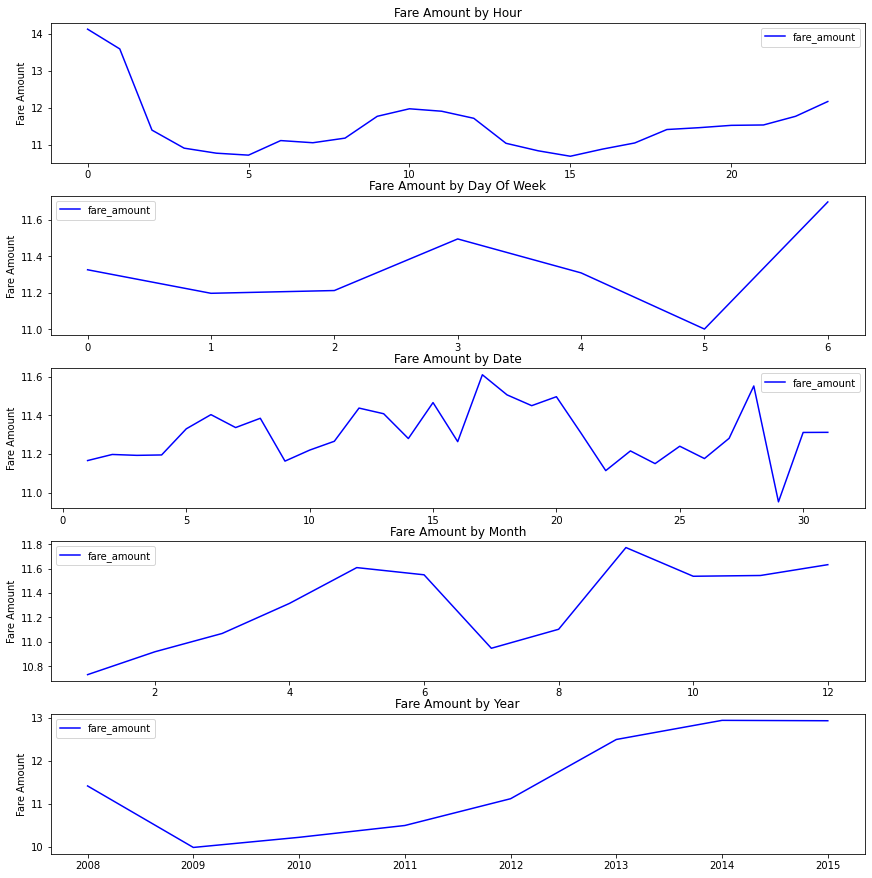

In [76]:
time_slicer(df=df, timeframes=['Hour', 'Day of Week','Date', 'Month', 'Year'], 
            value = "fare_amount", color="blue")

1) From fare by hour, between 8am to 12am, fare price increases due to heavy demand with usual morning rush hour. Similarly, the fare increases steadily after 5pm all the way to midnight. Usually, taxi fare later into the night is priced higher than usual due to lower number of taxi's available.

2) On the weekend, fare prices tend to increase drastically due to high mobility amongst NYC's population.

3) Fare tends to increase mid year and towards the end of the year. This could be due to increase tourist activity during the long summer break and festive season.

4) Fare prices has been increasing over the years due to inflation and increase economic activity after the 08 crisis, thus bringing in many working and vacation tourist.

5) Date of the month doesnt show any significant influence over fare prices

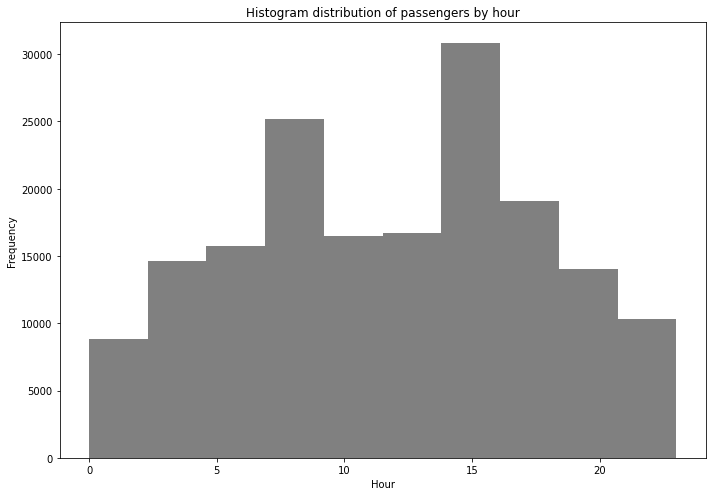

In [77]:
fig, axs = plt.subplots(1, 1,
                        figsize =(10, 7),
                        tight_layout = True)
 
axs.hist(df['Hour'],color = 'grey')
axs.set_xlabel('Hour')
axs.set_ylabel('Frequency')
axs.set_title('Histogram distribution of passengers by hour')
 
# Show plot
plt.show()

By comparing the histogram distribution of passengers by hour and comparing with fare amount by hour from previous plot, we can conclude that due to the high demand at approximately 8am and 4pm, taxi fares begin increasing steadily. The sharp drop in demand after 10am, results in the fare prices dropping as well. 

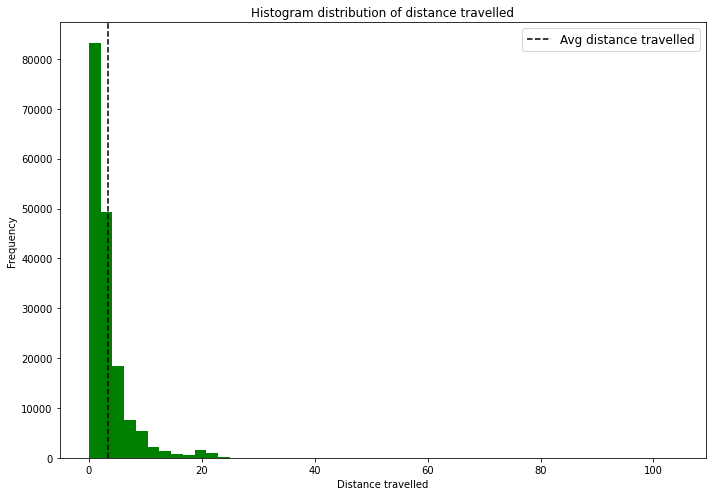

In [78]:
fig, axs = plt.subplots(1, 1,
                        figsize =(10, 7),
                        tight_layout = True)
 
axs.hist(df['distance'], bins = 50, color = 'green')
axs.axvline(df["distance"].mean(),color = "k",
            linestyle = "dashed",label = "Avg distance travelled")
axs.set_xlabel('Distance travelled')
axs.set_ylabel('Frequency')
axs.set_title('Histogram distribution of distance travelled')
axs.legend(loc = "best",prop = {"size" : 12})
 
# Show plot
plt.show()

From the histogram above, most passengers travel less than 10km with a mean value of 3.330725km. Only a small minority of them travel for long distances.

----
----

## Feature Engineering

In [124]:
df2 = df.copy() #copy dataframe
df2.dtypes

fare_amount                             float64
pickup_datetime      datetime64[ns, US/Eastern]
pickup_longitude                        float64
pickup_latitude                         float64
dropoff_longitude                       float64
dropoff_latitude                        float64
passenger_count                           int64
pickup_loc                               object
dropoff_loc                              object
distance                                float64
Year                                      int32
Month                                      int8
Date                                       int8
Day of Week                                int8
Hour                                       int8
dtype: object

In [125]:
# Drop pickup_loc and dropoff_loc since it was used only for visualization
# Drop pickup_datetime as it has been transformed to multiple columns for time specific metrics
df2.drop(['pickup_loc', 'dropoff_loc', 'pickup_datetime'], axis = 1, inplace = True)

# Drop geocordinates related features as we have used it to derived distance feature 
df2.drop(['pickup_longitude', 'pickup_latitude', 'dropoff_longitude', 'dropoff_latitude'], axis = 1, inplace = True)

In [126]:
df2.describe()

,fare_amount,passenger_count,distance,Year,Month,Date,Day of Week,Hour
count,171835.000000,171835.000000,171835.000000,171835.000000,171835.000000,171835.000000,171835.000000,171835.000000
mean,11.305676,1.595862,3.330725,2011.711229,6.277132,15.686944,2.982803,11.798533
std,9.631033,1.153893,3.813453,1.867284,3.445626,8.673130,1.906335,5.836334
min,2.500000,1.000000,0.000000,2008.000000,1.000000,1.000000,0.000000,0.000000
25%,6.000000,1.000000,1.255086,2010.000000,3.000000,8.000000,1.000000,7.000000
50%,8.500000,1.000000,2.152658,2012.000000,6.000000,16.000000,3.000000,12.000000
75%,12.500000,2.000000,3.901296,2013.000000,9.000000,23.000000,5.000000,17.000000
max,200.000000,5.000000,104.035108,2015.000000,12.000000,31.000000,6.000000,23.000000


**Feature Transformation**

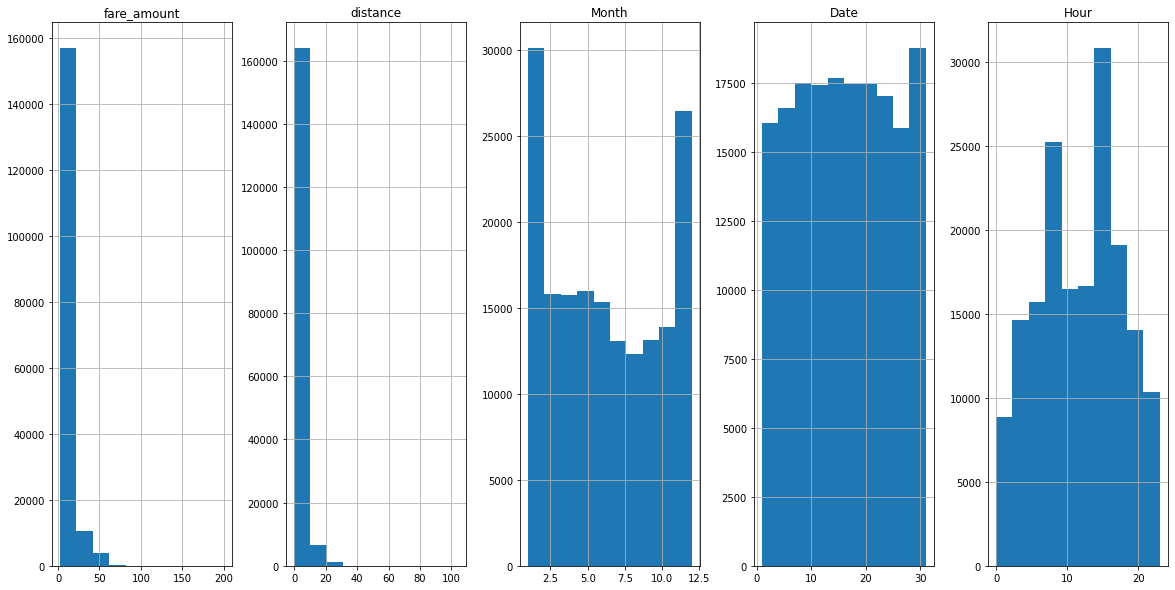

In [130]:
columns = ['fare_amount','distance','Month', 'Date', 'Hour']
fig, axs = plt.subplots(1, 5, figsize=(20, 10))

hist_df = df2
for ax, col in zip(axs.flatten(), columns):
    hist_df.hist(column=col, ax=ax)


Fare_amount and distance features are heavily skewed to the right. This features would require transformation to approximate it into a normal distribution

In [131]:
# Before applying feature transformation and scaling, copy the dataset
# For building tree based models, the dataset used for training would not required feature transformation and scaling
# df2 non-tree based learners
# df3 tree-based learners

df3 = df2.copy()

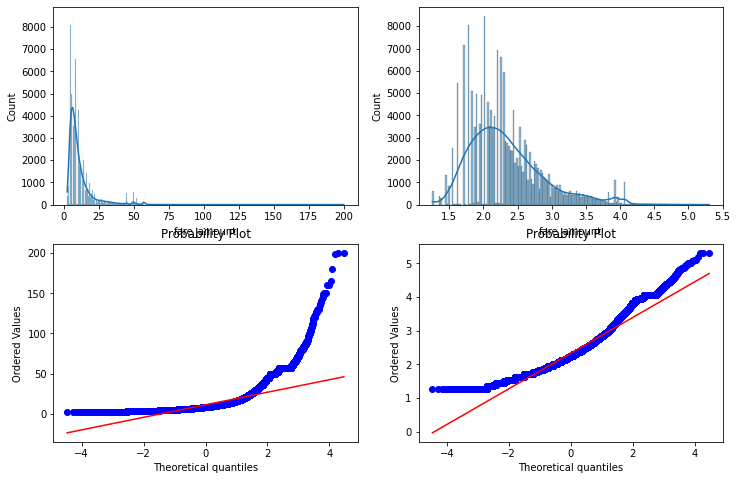

In [132]:
plot , ax = plt.subplots(2 , 2 , figsize = (12 , 8))
g = sns.histplot(df2['fare_amount'] , kde = True , ax = ax[0][0])
res = stats.probplot(df2['fare_amount'], plot= ax[1][0])

fare_amount = np.log1p(df2['fare_amount'])
g = sns.histplot(fare_amount , kde = True , ax = ax[0][1])
res = stats.probplot(fare_amount, plot= ax[1][1])

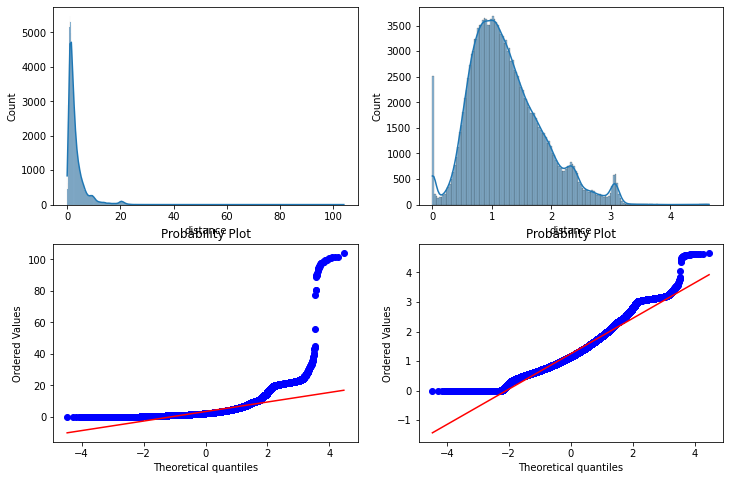

In [133]:
plot , ax = plt.subplots(2 , 2 , figsize = (12 , 8))
g = sns.histplot(df2['distance'] , kde = True , ax = ax[0][0])
res = stats.probplot(df2['distance'], plot= ax[1][0])

distance = np.log1p(df2['distance'])
g = sns.histplot(distance , kde = True , ax = ax[0][1])
res = stats.probplot(distance, plot= ax[1][1])

Finalizing transformation

In [ ]:
df2['fare_amount'] = np.log1p(df2['fare_amount'])
df2['distance'] = np.log1p(df2['distance'])
# Apply MinMax normnalization on independent features

scaler = MinMaxScaler()
df2[['passenger_count','distance', 'Year', 'Month', 'Date', 'Day of Week', 'Hour']] = scaler.fit_transform(df2[['passenger_count','distance', 'Year', 'Month',
                                                                                                                'Date', 'Day of Week', 'Hour']])

In [134]:
df2['fare_amount'] = np.log1p(df2['fare_amount'])
df2['distance'] = np.log1p(df2['distance'])

In [135]:
print(df2['fare_amount'].describe())
print(df2['distance'].describe())

count    171835.000000
mean          2.331120
std           0.545956
min           1.252763
25%           1.945910
50%           2.251292
75%           2.602690
max           5.303305
Name: fare_amount, dtype: float64
count    171835.000000
mean          1.246863
std           0.611075
min           0.000000
25%           0.813188
50%           1.148246
75%           1.589500
max           4.654295
Name: distance, dtype: float64


**Feature Scaling**

In [138]:
# Apply MinMax normnalization on independent features

scaler = MinMaxScaler()
df2[['passenger_count','distance', 'Year', 'Month', 'Date', 'Day of Week', 'Hour']] = scaler.fit_transform(df2[['passenger_count','distance', 'Year', 'Month',
                                                                                                                'Date', 'Day of Week', 'Hour']])

In [139]:
df2.describe()

,fare_amount,passenger_count,distance,Year,Month,Date,Day of Week,Hour
count,171835.000000,171835.000000,171835.000000,171835.000000,171835.000000,171835.000000,171835.000000,171835.000000
mean,2.331120,0.148966,0.267895,0.530176,0.479739,0.489565,0.497134,0.512980
std,0.545956,0.288473,0.131293,0.266755,0.313239,0.289104,0.317722,0.253754
min,1.252763,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,1.945910,0.000000,0.174718,0.285714,0.181818,0.233333,0.166667,0.304348
50%,2.251292,0.000000,0.246707,0.571429,0.454545,0.500000,0.500000,0.521739
75%,2.602690,0.250000,0.341512,0.714286,0.727273,0.733333,0.833333,0.739130
max,5.303305,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


----
----

## Feature Selection

In [116]:
x = df2.iloc[:,1:]
y = df2.iloc[:,0]

Univariate linear regression tests returning F-statistic and p-values

In [141]:
# configure to select all features
fs = SelectKBest(score_func = f_regression, k='all')
# learn relationship from training data
fs.fit(x, y)
# transform train input data
x_fs = fs.transform(x)

Feature 0: 10.340488
Feature 1: 436301.523587
Feature 2: 3556.491448
Feature 3: 149.223639
Feature 4: 0.001148
Feature 5: 13.970210
Feature 6: 61.634790


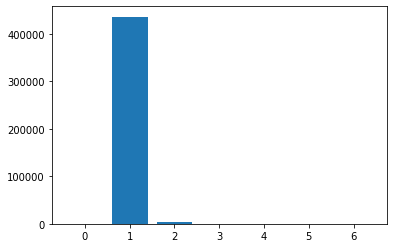

In [146]:
for i in range(len(fs.scores_)):
	print('Feature %d: %f' % (i, fs.scores_[i]))
# plot the scores
pyplot.bar([i for i in range(len(fs.scores_))], fs.scores_)
pyplot.show()

From the feature selection metric, distance is by far the most influential feature for predicting fare price. In view of developing a parsimonious model, we select only the best 5 independent features. Feature 0 (passenger_count) and Feature 4 (Date) will be discarded

In [147]:
df2.drop(['passenger_count', 'Date'], axis = 1, inplace = True)
df2.head()

,fare_amount,distance,Year,Month,Day of Week,Hour
0,1.704748,0.152206,0.142857,0.454545,0.000000,0.565217
1,2.884801,0.482572,0.285714,0.000000,0.166667,0.478261
2,1.902108,0.187160,0.428571,0.636364,0.333333,0.869565
3,2.163323,0.286791,0.571429,0.272727,0.833333,0.000000
4,1.840550,0.235983,0.285714,0.181818,0.166667,0.086957


Pass test set through same Preprocessing and Feature Engineering pipeline

In [41]:
# Import Testing Set
df_test = pd.read_csv('/notebooks/NYC_Fare_Prediction_Reg/testing_dataset.csv', parse_dates=['pickup_datetime']) #Parse dates into date format

# Drop Key
df_test.drop(['key'], axis = 1, inplace = True )

# Bound fare_amount between the range of USD 2.5 to 200
df_test = df_test.drop(df_test[df_test.fare_amount < 2.5].index, axis = 0)
df_test = df_test.drop(df_test[df_test.fare_amount > 200].index, axis = 0)

# Bound passenger_count between the range of 1 to 5
df_test = df_test.drop(df_test[df_test.passenger_count == 0].index, axis = 0)
df_test = df_test.drop(df_test[df_test.passenger_count > 5].index, axis = 0)

# Drop unrealistic longitute and latitude observations
df_test = df_test.drop(df_test[df_test.dropoff_longitude < -180].index, axis = 0)
df_test = df_test.drop(df_test[df_test.dropoff_longitude > 180].index, axis = 0)

df_test = df_test.drop(df_test[df_test.pickup_longitude < -180].index, axis = 0)
df_test = df_test.drop(df_test[df_test.pickup_longitude > 180].index, axis = 0)

df_test = df_test.drop(df_test[df_test.dropoff_latitude < -90].index, axis = 0)
df_test = df_test.drop(df_test[df_test.dropoff_latitude > 90].index, axis = 0)

df_test = df_test.drop(df_test[df_test.pickup_latitude < -90].index, axis = 0)
df_test = df_test.drop(df_test[df_test.pickup_latitude > 90].index, axis = 0)

# Find Non-locations
bb = (-74.5, -72.8, 40.5, 41.8)
non_locations_test = select_outside_boundingbox(df_test, bb)
non_locations_test.head()

# Drop Non-location
df_test = df_test.drop(non_locations_test.index, axis = 0)

# Compute Distance
df_test['pickup_loc'] = df_test[['pickup_latitude', 'pickup_longitude']].apply(tuple, axis = 1)
df_test['dropoff_loc'] = df_test[['dropoff_latitude', 'dropoff_longitude']].apply(tuple, axis = 1)
df_test['distance'] = df_test.apply(lambda row: hs.haversine(row.pickup_loc,row.dropoff_loc), axis=1)

# Convert time data
conv_time_data(df_test)

# Drop pickup_datetime as it has been transformed to multiple columns for time specific metrics
df_test.drop(['pickup_loc', 'dropoff_loc', 'pickup_datetime'], axis = 1, inplace = True)

# Drop geocordinates related features as we have used it to derived distance feature 
df_test.drop(['pickup_longitude', 'pickup_latitude', 'dropoff_longitude', 'dropoff_latitude'], axis = 1, inplace = True)

# Drop these features as part of feature selection
df_test.drop(['passenger_count', 'Date'], axis = 1, inplace = True)

In [55]:
df_test2 = df_test.copy()

# Apply log transformation to distance and fare_amount
df_test2['distance'] = np.log1p(df_test2['distance'])
df_test2['fare_amount'] = np.log1p(df_test2[['fare_amount']])

# Apply MinMax normnalization on independent features
scaler = MinMaxScaler()
df_test2[['distance', 'Year', 'Month', 'Day of Week', 'Hour']] = scaler.fit_transform(df_test2[['distance', 
                                                                                                 'Year', 'Month','Day of Week', 'Hour']])

In [12]:
x_test = df_test.iloc[:,1:]
y_test = df_test.iloc[:,0]

In [59]:
x_test_2 = df_test2.iloc[:,1:]
y_test_2 = df_test2.iloc[:,0]

--------
--------

## Modelling

**Training and Evaluation**

Use non-transformed and non-scaled dataset for tree based models -> df3

In [6]:
df3 = pd.read_csv('/notebooks/NYC_Fare_Prediction_Reg/df3.csv')

In [7]:
df3.drop(['passenger_count', 'Date'], axis = 1, inplace = True)

In [8]:
x1 = df3.iloc[:,1:]
y1 = df3.iloc[:,0]

Split dataset into training and validation

In [9]:
x_train_1, x_valid_1, y_train_1, y_valid_1 = train_test_split(x1, y1, test_size = 0.2, random_state = 897)

------------

**Model 1 - Decision Tree Regressor**

In [37]:
dt = DecisionTreeRegressor()
dt.fit(x_train_1, y_train_1)

DecisionTreeRegressor()

In [16]:
# Using Decision Tree model, predict the output for x_valid_1
y_dt_pred_train = dt.predict(x_train_1)
y_dt_pred_valid = dt.predict(x_valid_1)


# Compute the model's rmse value
rmse_train = np.sqrt(mean_squared_error(y_train_1, y_dt_pred_train))
print("RMSE for training: %f" % (rmse_train))

rmse_valid = np.sqrt(mean_squared_error(y_valid_1, y_dt_pred_valid))
print("RMSE for validation: %f" % (rmse_valid))

RMSE for training: 0.202359
RMSE for validation: 6.537448


As anticipated, Decision Tree is severely prone to overfitting. Hence to resolve this, we tune the model to develop a generalized model

**Tuned Decision Tree**

In [ ]:
# Use GRID SEARCH CV
# Define Parameter Grid
param_grid = {"min_samples_split": [3, 10, 20, 40],
              "max_depth": [2, 7, 8, 10],
              "min_samples_leaf": [15, 20, 40, 100],
              "max_leaf_nodes": [5, 20, 100, 200],
              }

# Tune hyperparameters using GridSearch technique
grid_cv_dt = GridSearchCV(dt, param_grid, cv=5, verbose=2.5)
grid_cv_dt.fit(x_train_1, y_train_1)

In [ ]:
print('Best Hyperparameters for DT:', format(grid_cv_dt.best_params_))

In [21]:
#Train decision tree with best hyperparameters

dt_tuned = DecisionTreeRegressor( max_depth=8, max_leaf_nodes=200, min_samples_leaf=20, min_samples_split=3)
dt_tuned.fit(x_train_1, y_train_1)

DecisionTreeRegressor(max_depth=8, max_leaf_nodes=200, min_samples_leaf=20,
                      min_samples_split=3)

In [22]:
# Using Decision Tree model, predict the output for x_valid_1
y_dt_tuned_pred_train = dt_tuned.predict(x_train_1)
y_dt_tuned_pred_valid = dt_tuned.predict(x_valid_1)

# Compute the model's rmse value
rmse_train_dt = np.sqrt(mean_squared_error(y_train_1, y_dt_tuned_pred_train))
print("RMSE for training: %f" % (rmse_train_dt))

rmse_valid_dt = np.sqrt(mean_squared_error(y_valid_1, y_dt_tuned_pred_valid))
print("RMSE for validation: %f" % (rmse_valid_dt))

RMSE for training: 4.346953
RMSE for validation: 4.474031


In [23]:
y_dt_tuned_pred_test = dt_tuned.predict(x_test)
rmse_test_dt= np.sqrt(mean_squared_error(y_test, y_dt_tuned_pred_test))
print("RMSE for testing: %f" % (rmse_test_dt))

RMSE for testing: 4.768263


---------

**Model 2 - XGB.Regressor (Tuned)**

In [ ]:
import time
import xgboost as xgb
%time

params = {'max_depth': [4, 6, 10],
          'eta': [0.2, 0.3, 0.5],
          'n_estimators': [100, 150, 200],
          'colsample_bytree': [0.4, 0.6],
          'subsample': [0.4, 0.6],
          'booster': ['gbtree']}

xgb_r = xgb.XGBRegressor(seed=20)

gridsearchCV_XGB = GridSearchCV(estimator=xgb_r, param_grid=params, cv=4, verbose=1.5)
gridsearchCV_XGB.fit(x_train_1, y_train_1)

In [26]:
print("Best parameters:", gridsearchCV_XGB.best_params_)

Best parameters: {'booster': 'gbtree', 'colsample_bytree': 0.6, 'eta': 0.2, 'max_depth': 4, 'n_estimators': 100, 'subsample': 0.6}


In [27]:
xgb_r = xgb.XGBRegressor(max_depth=4, eta=0.2, n_estimators=100, colsample_bytree=0.6, subsample=0.6, booster='gbtree' )
xgb_r.fit(x_train_1, y_train_1)

XGBRegressor(base_score=0.5, booster='gbtree', callbacks=None,
             colsample_bylevel=1, colsample_bynode=1, colsample_bytree=0.6,
             early_stopping_rounds=None, enable_categorical=False, eta=0.2,
             eval_metric=None, gamma=0, gpu_id=-1, grow_policy='depthwise',
             importance_type=None, interaction_constraints='',
             learning_rate=0.200000003, max_bin=256, max_cat_to_onehot=4,
             max_delta_step=0, max_depth=4, max_leaves=0, min_child_weight=1,
             missing=nan, monotone_constraints='()', n_estimators=100, n_jobs=0,
             num_parallel_tree=1, predictor='auto', random_state=0, reg_alpha=0, ...)

In [28]:
# Using XGBoost model, predict the output for x_valid_1
y_xgb_tuned_pred_train = xgb_r.predict(x_train_1)
y_xgb_tuned_pred_valid = xgb_r.predict(x_valid_1)

# Compute the model's rmse value
rmse_train_xgb = np.sqrt(mean_squared_error(y_train_1, y_xgb_tuned_pred_train))
print("RMSE for training: %f" % (rmse_train_xgb))

rmse_valid_xgb = np.sqrt(mean_squared_error(y_valid_1, y_xgb_tuned_pred_valid))
print("RMSE for validation: %f" % (rmse_valid_xgb))

RMSE for training: 4.346953
RMSE for validation: 4.474031


In [33]:
y_xgb_tuned_pred_test = xgb_r.predict(x_test)
rmse_test_xgb= np.sqrt(mean_squared_error(y_test, y_xgb_tuned_pred_test))
print("RMSE for testing: %f" % (rmse_test_xgb))

RMSE for testing: 4.697526


---------

**Model 3 - Random Forest (Tuned)**

In [14]:
from sklearn.ensemble import RandomForestRegressor

param_grid = {
    'bootstrap': [True, False],
    'max_depth': [6, 8, 10],
    'min_samples_leaf': [5, 10, 15],
    'min_samples_split': [2, 6, 10],
    'n_estimators': [80, 120, 150, 200]
}

rf_reg = RandomForestRegressor()
grid_search_rf = GridSearchCV(estimator=rf_reg, param_grid=param_grid, 
                              cv=4, verbose=1.5)

In [ ]:
grid_search_rf.fit(x_train_1, y_train_1)

In [15]:
rf_tuned = RandomForestRegressor(bootstrap=True, min_samples_leaf=10, n_estimators=150, max_depth=8, min_samples_split=6)
rf_tuned.fit(x_train_1, y_train_1)

RandomForestRegressor(max_depth=8, min_samples_leaf=10, min_samples_split=6,
                      n_estimators=150)

In [16]:
# Using XGBoost model, predict the output for x_valid_1
y_rf_tuned_pred_train = rf_tuned.predict(x_train_1)
y_rf_tuned_pred_valid = rf_tuned.predict(x_valid_1)

# Compute the model's rmse value
rmse_train_rf = np.sqrt(mean_squared_error(y_train_1, y_rf_tuned_pred_train))
print("RMSE for training: %f" % (rmse_train_rf))

rmse_valid_rf = np.sqrt(mean_squared_error(y_valid_1, y_rf_tuned_pred_valid))
print("RMSE for validation: %f" % (rmse_valid_rf))

RMSE for training: 4.283554
RMSE for validation: 4.412543


In [17]:
y_rf_tuned_pred_test = rf_tuned.predict(x_test)
rmse_test_rf= np.sqrt(mean_squared_error(y_test, y_rf_tuned_pred_test))
print("RMSE for testing: %f" % (rmse_test_rf))

RMSE for testing: 4.683884


-----------

**Model 4 - Support Vector Machines**

Use transformed and scaled dataset -> df2

In [4]:
df2 = pd.read_csv('/notebooks/NYC_Fare_Prediction_Reg/df2.csv')

In [5]:
df2_x1 = df2.iloc[:,1:]
df2_y1 = df2.iloc[:,0]

In [6]:
x_train_df2, x_valid_df2, y_train_df2, y_valid_df2 = train_test_split(df2_x1, df2_y1, test_size = 0.2, random_state = 897)

In [ ]:
from sklearn.svm import SVR

params = {'C': [0.1,1, 10], 
          'gamma': [1,0.1,0.01],
          'kernel': ['rbf', 'poly', 'sigmoid']}

svm = SVR()
grid_search_svm = GridSearchCV(estimator = svm, param_grid = params, cv = 4, verbose=1.5)
grid_search_svm.fit(x_train_df2, y_train_df2)

Fitting 4 folds for each of 27 candidates, totalling 108 fits


In [10]:
from sklearn.svm import SVR
svm_tuned = SVR(C=1, gamma=0.1, kernel='rbf')
svm_tuned.fit(x_train_df2, y_train_df2)

SVR(C=1, gamma=0.1)

In [11]:
# Using XGBoost model, predict the output for x_valid_1
y_svm_tuned_pred_train = svm_tuned.predict(x_train_df2)
y_svm_tuned_pred_valid = svm_tuned.predict(x_valid_df2)

# Compute the model's rmse value
rmse_train_svm = np.sqrt(mean_squared_error(y_train_df2, y_svm_tuned_pred_train))
print("RMSE for training: %f" % (rmse_train_svm))

rmse_valid_svm = np.sqrt(mean_squared_error(y_valid_df2, y_svm_tuned_pred_valid))
print("RMSE for validation: %f" % (rmse_valid_svm))

RMSE for training: 0.272545
RMSE for validation: 0.270359


In [60]:
y_svm_tuned_pred_test = svm_tuned.predict(x_test_2)
rmse_test_svm= np.sqrt(mean_squared_error(y_test_2, y_svm_tuned_pred_test))
print("RMSE for testing: %f" % (rmse_test_svm))


RMSE for testing: 0.274319


**Model Performances**

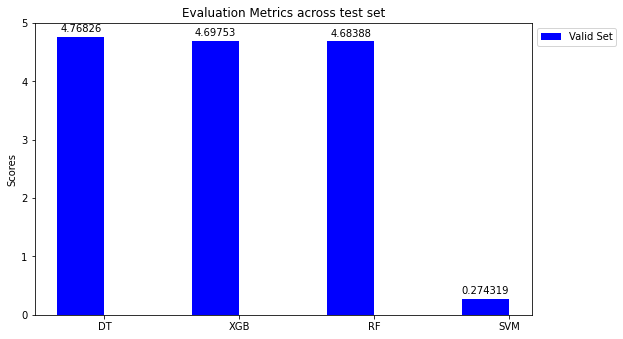

In [68]:
labels = ['DT', 'XGB', 'RF', 'SVM' ]
test_metrics = [rmse_test_dt, rmse_test_xgb, rmse_test_rf, rmse_test_svm]

x = np.arange(len(labels))
width = 0.35

fig, ax = plt.subplots()
rects1 = ax.bar(x - width/2, test_metrics, width, color='b', label='Valid Set')

ax.set_ylabel('Scores')
ax.set_ylim([0, 5])
ax.set_title('Evaluation Metrics across test set')
ax.set_xticks(x, labels)
plt.legend(bbox_to_anchor=(1.0, 1.0), loc='upper left')

ax.bar_label(rects1, padding=3)

fig.tight_layout()
fig.set_size_inches(10, 5)

plt.show()